# MA 再評価

### プロジェクトのルートのパスを通す

In [1]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

### ライブラリを一括インポート

In [2]:
import os
import re

import matplotlib.dates as mdates
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.interpolate import griddata

from funcs.ios import get_excel_sheet
from funcs.technical import CappedPriceMovement, MovingAverage
from funcs.tide import conv_datetime_from_timestamp

### Matplotlib のフォント設定（オプション）

In [3]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()

## ティックデータの取得

In [4]:
excel = "ticks_20251212.xlsx"
code = "7011"  # 銘柄コード

path_dir = os.path.join("..", "collection")
path_excel = os.path.join(path_dir, excel)
df = get_excel_sheet(path_excel, code)
df

,Time,Price,Volume
0,1.765498e+09,4100,2107900
1,1.765498e+09,4100,2107900
2,1.765498e+09,4101,2222400
3,1.765498e+09,4101,2222400
4,1.765498e+09,4103,2326100
...,...,...,...
19401,1.765521e+09,4162,21563600
19402,1.765521e+09,4162,21563600
19403,1.765521e+09,4162,21563700
19404,1.765521e+09,4162,21563700


In [5]:
df.index = [pd.to_datetime(conv_datetime_from_timestamp(ts)) for ts in df["Time"]]
df

,Time,Price,Volume
2025-12-12 09:00:45,1.765498e+09,4100,2107900
2025-12-12 09:00:46,1.765498e+09,4100,2107900
2025-12-12 09:00:47,1.765498e+09,4101,2222400
2025-12-12 09:00:48,1.765498e+09,4101,2222400
2025-12-12 09:00:49,1.765498e+09,4103,2326100
...,...,...,...
2025-12-12 15:24:55,1.765521e+09,4162,21563600
2025-12-12 15:24:56,1.765521e+09,4162,21563600
2025-12-12 15:24:57,1.765521e+09,4162,21563700
2025-12-12 15:24:58,1.765521e+09,4162,21563700


In [6]:
n_1 = 90
ma_1 = MovingAverage(window_size=n_1)
df["MA1"] = [ma_1.update(v) for v in df["Price"]]
n_2 = 900
ma_2 = MovingAverage(window_size=n_2)
df["MA2"] = [ma_2.update(v) for v in df["Price"]]
# ２つの MA の差分
df["DMA"] = df["MA1"] - df["MA2"] 
# Capped Price Movement
n_3 = 30
cpm = CappedPriceMovement(window_size=n_3)
df["CPM"] = [cpm.update(v) for v in df["Price"]]
df

,Time,Price,Volume,MA1,MA2,DMA,CPM
2025-12-12 09:00:45,1.765498e+09,4100,2107900,4100.000000,4100.000000,0.000000,0.0
2025-12-12 09:00:46,1.765498e+09,4100,2107900,4100.000000,4100.000000,0.000000,0.0
2025-12-12 09:00:47,1.765498e+09,4101,2222400,4100.333333,4100.333333,0.000000,1.0
2025-12-12 09:00:48,1.765498e+09,4101,2222400,4100.500000,4100.500000,0.000000,1.0
2025-12-12 09:00:49,1.765498e+09,4103,2326100,4101.000000,4101.000000,0.000000,3.0
...,...,...,...,...,...,...,...
2025-12-12 15:24:55,1.765521e+09,4162,21563600,4161.433333,4171.956667,-10.523333,1.0
2025-12-12 15:24:56,1.765521e+09,4162,21563600,4161.444444,4171.942222,-10.497778,1.0
2025-12-12 15:24:57,1.765521e+09,4162,21563700,4161.455556,4171.927778,-10.472222,1.0
2025-12-12 15:24:58,1.765521e+09,4162,21563700,4161.466667,4171.914444,-10.447778,1.0


## クロス処理

In [7]:
# ============================
# 1. クロス検出（+1 / -1 / 0）
# ============================
golden = ((df["DMA"].shift(1) < 0) & (df["DMA"] > 0)).astype(int)
dead   = ((df["DMA"].shift(1) > 0) & (df["DMA"] < 0)).astype(int) * -1

df["Cross"] = (golden + dead).astype("int8")  # 軽量で扱いやすい

# ============================
# 2. 傾き（diff → 軽い平滑化）
# ============================
df["Slope_MA1"] = df["MA1"].diff().rolling(5).mean()
df["Slope_MA2"] = df["MA2"].diff().rolling(5).mean()

# ============================
# 3. 傾きの方向が異なるか
# ============================
df["Slope_Direction_Diff"] = (df["Slope_MA1"] * df["Slope_MA2"] < 0)

# ============================
# 4. 傾きの強さフィルタ（MA1）
# ============================
threshold = 0.01
df["Strong_Slope"] = df["Slope_MA1"].abs() > threshold

# ============================
# 5. 最終エントリー条件
# ============================
df["Entry"] = (
    (df["Cross"] != 0)
    #& df["Slope_Direction_Diff"]
    & df["Strong_Slope"]
)

df

,Time,Price,Volume,MA1,MA2,DMA,CPM,Cross,Slope_MA1,Slope_MA2,Slope_Direction_Diff,Strong_Slope,Entry
2025-12-12 09:00:45,1.765498e+09,4100,2107900,4100.000000,4100.000000,0.000000,0.0,0,NaN,NaN,False,False,False
2025-12-12 09:00:46,1.765498e+09,4100,2107900,4100.000000,4100.000000,0.000000,0.0,0,NaN,NaN,False,False,False
2025-12-12 09:00:47,1.765498e+09,4101,2222400,4100.333333,4100.333333,0.000000,1.0,0,NaN,NaN,False,False,False
2025-12-12 09:00:48,1.765498e+09,4101,2222400,4100.500000,4100.500000,0.000000,1.0,0,NaN,NaN,False,False,False
2025-12-12 09:00:49,1.765498e+09,4103,2326100,4101.000000,4101.000000,0.000000,3.0,0,NaN,NaN,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-12 15:24:55,1.765521e+09,4162,21563600,4161.433333,4171.956667,-10.523333,1.0,0,0.002222,-0.014000,True,False,False
2025-12-12 15:24:56,1.765521e+09,4162,21563600,4161.444444,4171.942222,-10.497778,1.0,0,0.004444,-0.014444,True,False,False
2025-12-12 15:24:57,1.765521e+09,4162,21563700,4161.455556,4171.927778,-10.472222,1.0,0,0.006667,-0.014444,True,False,False
2025-12-12 15:24:58,1.765521e+09,4162,21563700,4161.466667,4171.914444,-10.447778,1.0,0,0.008889,-0.014222,True,False,False


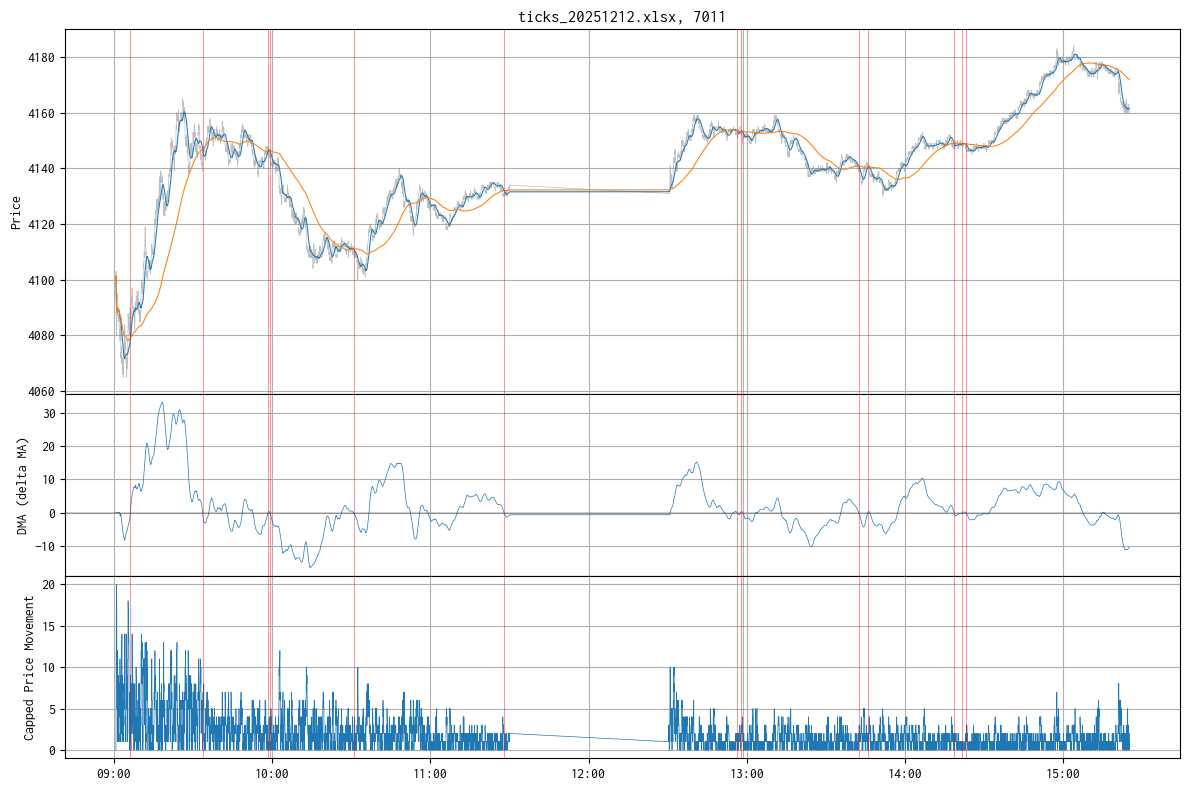

In [24]:
fig = plt.figure(figsize=(12, 8))
n = 3
ax = dict()
gs = fig.add_gridspec(n, 1, wspace=0.0, hspace=0.0, height_ratios=[2 if i == 0 else 1 for i in range(n)])
for i, axis in enumerate(gs.subplots(sharex="col")):
    ax[i] = axis
    ax[i].grid()

ax[0].plot(df["Price"], linewidth=0.5, color="gray", alpha=0.5)
ax[0].plot(df["MA1"], linewidth=0.75)
ax[0].plot(df["MA2"], linewidth=0.75)
ax[0].set_ylabel("Price")
ax[0].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax[0].set_title(f"{excel}, {code}")

ax[1].plot(df["DMA"], linewidth=0.5)
ax[1].axhline(0, linewidth=0.25, color="black")
ax[1].set_ylabel("DMA (delta MA)")

ax[2].plot(df["CPM"], linewidth=0.5)
ax[2].set_ylabel("Capped Price Movement")

entry_times = df.index[df["Entry"] & (df["CPM"] < 2)]
#entry_times = df.index[df["Cross"] != 0]
for t in entry_times:
    ax[0].axvline(t, color="red", linewidth=0.5, alpha=0.6)
    ax[1].axvline(t, color="red", linewidth=0.5, alpha=0.6)
    ax[2].axvline(t, color="red", linewidth=0.5, alpha=0.6)

plt.tight_layout()
output = os.path.join(
    "..", "tmp", "dma.png"
)
plt.tight_layout()
plt.savefig(output)
plt.show()